### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [17]:
import sys  
sys.path.insert(0, '../')

import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math
from matplotlib import cm
import matplotlib 

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 1

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [18]:
hyperparameterspace = {
    'x0': ["interval", -5, 10],
    'x1': ["interval", -5, 10],
    #'learning_rate': ["interval-log", 0.000000001, 0.1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Experiment parameters

In [19]:
DIRECTORY = "Current_tests/"+time.strftime("%H_%M_%S", time.localtime())

SPARSE_PARAMS = [2, 0.85, "gradient_descent"]

BUDGETS = [10]

### Optimization


################################################## Current Budget: 1000 ##################################################

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 48ms.
########### Generated Grid: ###########


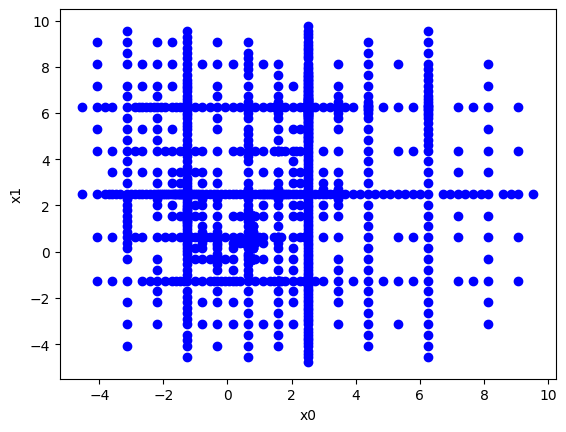

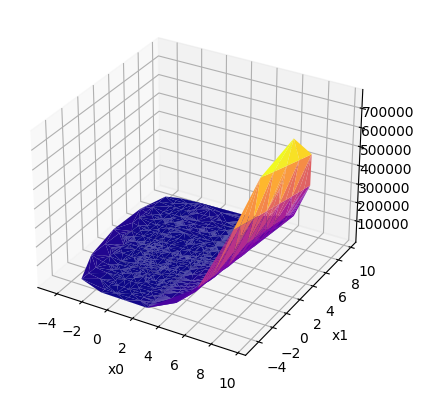

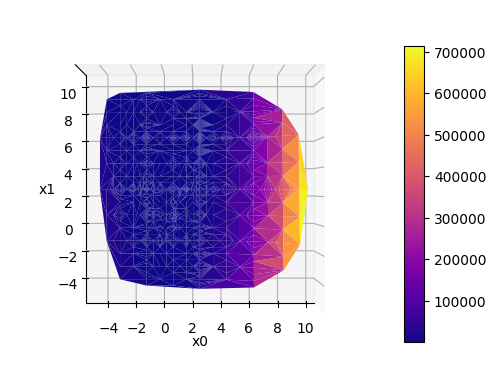

Solving linear system (automatic method)...
Done in 1434ms.

Optimal hyperparameters so far:
x0: 0.7913970947265625
x1: 0.625
Resulting loss:
0.04368661489260769
Optimizing (gradient descent)...

Optimal hyperparameters after local optimization:
x0: 0.7913970947265625
x1: 0.625
Resulting loss (Optimal value from optimization):
0.04368661489260769
Resulting loss (Optimal point evaluated):
0.04368661485319231
Done in 1ms.
Optimizing (multi-start)...
Done in 17ms.

Optimal hyperparameters after global optimization:
x0: 3.0852239366663703
x1: 9.509290405924332
Resulting loss (Optimal value from optimization):
-14.26349261177019
Resulting loss (Optimal point evaluated):
4.356838272950504


In [20]:
# os.mkdir(DIRECTORY)

# f = open(DIRECTORY+"/configurations.txt", "a")
# f.write("Dimension of hyperparameter space: " +
#         str(len(hyperparameterspace)) + "\n")
# for key in hyperparameterspace.keys():
#     f.write("\n" + key + ": " + str(hyperparameterspace[key]))
# f.write("\n\nSparse grid degree: " + str(SPARSE_PARAMS[0]))
# f.write("\nSparse grid adaptivity param: " + str(SPARSE_PARAMS[1]))
# f.write("\nSparse grid optimization alg: " + str(SPARSE_PARAMS[2]))
# f.write("\nBUDGETS: " + str(BUDGETS))
# f.close()


################## MODEL AND FUNCTION DEFINITION ####################

def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):

    ################# RASTRIGIN #################
    # sum = 0
    # sum += epochs ** 2 - 10 * math.cos(2 * math.pi * epochs)
    # sum += batch_size ** 2 - 10 * math.cos(2 * math.pi * batch_size)
    # # sum += learning_rate ** 2 - 10 * math.cos(2 * math.pi * learning_rate)
    # # sum += number_of_layers ** 2 - 10 * math.cos(2 * math.pi * number_of_layers)
    # # sum += neurons_per_layer ** 2 - 10 * math.cos(2 * math.pi * neurons_per_layer)
    # return len(hyperparameterspace) * 10 + sum

    ################# ROSENBROCK #################
    sum = 0
    sum += (1-epochs)**2 + 100 * (batch_size - epochs**2) ** 2
    return sum

    ################# EGGHOLDER #################
    # return -epochs * math.sin(math.sqrt(abs(epochs - (batch_size + 47)))) - (batch_size + 47) * math.sin(math.sqrt(abs((batch_size + 47 + 0.5 * epochs))))

    # return epochs + batch_size + learning_rate + number_of_layers + neurons_per_layer


class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(
            len(hyperparameterspace.keys()))

    def eval(self, x):
        # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = (HPO.from_standard(
            hyperparameterspace_special["x0"][0], hyperparameterspace_special["x0"][1], x[0]))

        batch_size = (HPO.from_standard(
            hyperparameterspace_special["x1"][0], hyperparameterspace_special["x1"][1], x[1]))

        # HPO.from_standard_log(hyperparameterspace_special["learning_rate"][
        model_learning_rate = 0
        #                  0], hyperparameterspace_special["learning_rate"][1], x[2])

        number_of_layers = 0  # int(HPO.from_standard(
        # hyperparameterspace_special["number_layers"][0], hyperparameterspace_special["number_layers"][1], x[3]))

        neurons_per_layer = 0  # int(HPO.from_standard(
        # hyperparameterspace_special["neurons_per_layer"][0], hyperparameterspace_special["neurons_per_layer"][1], x[4]))

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)


# resolution = 200

# x = np.linspace(-2, 8, resolution)
# y = np.linspace(-2, 8, resolution)

# X, Y = np.meshgrid(x, y)

# Z = np.zeros((resolution, resolution))

# for i in range(resolution):
#     for j in range(resolution):
#         Z[i][j] = evaluate_model(X[i][j], Y[i][j], 0, 0, 0)


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# surface = ax.plot_surface(X, Y, Z, cmap='plasma')
# ax.set_xlabel('x0')
# ax.set_ylabel('x1')
# ax.set_zlabel('y')
# fig.colorbar(surface, shrink=0.8, aspect=15)
# plt.savefig("./Testfunctions/Rastrigin_normal.pgf",bbox_inches='tight' )
# plt.show()


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# surface = ax.plot_surface(X, Y, Z, cmap='plasma')
# ax.set_xlabel('x0')
# ax.set_ylabel('x1')
# ax.set_zlabel('y')
# ax.set_zticks([])
# ax.view_init(90, 270)
# fig.colorbar(surface, shrink=0.8, aspect=15)
# plt.savefig("./Testfunctions/Rastrigin_above.pgf",bbox_inches='tight' )
# plt.show()

#### For each dataset: run models with different budget #####
for BUDGET in BUDGETS:

    print("\n################################################## Current Budget:",
            BUDGET, "##################################################")

    ########################### SPARSE OPT ############################

    print("\nPerforming sparse search")

    f = ExampleFunction()
    dataset = HPO.Dataset([], [])

    optimization = HPO.SparseGridSearchOptimization(
        dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=SPARSE_PARAMS[0], adaptivity=SPARSE_PARAMS[1], optimizer=SPARSE_PARAMS[2])

    [x0, fX0, x1, fX1, x2, fX2], cost  = optimization.fit()

    # print("Best result from sparse grid:")
    # print(x0)
    # print(fX0)

    # print("Best result from local optimization:")
    # print(x1)
    # print(fX1)

    # print("Best result from global optimization:")
    # print(x2)
    # print(fX2)

    # print("Cost:")
    # print(cost)


